In [1]:
%load_ext autoreload
%autoreload 2
    

In [2]:
import pandas as pd
import numpy as np
import sys

import bets
import os
import glob
import datetime as dt
import time
#import ot
import json
import requests
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import sidetable
nba = bets.nba()
import seaborn as sns
import matplotlib.pyplot as plt
import re
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from nba_api.stats.endpoints import leaguegamefinder,BoxScoreSummaryV2,LeagueDashOppPtShot,PlayerProfileV2,GameRotation,LeagueDashPlayerShotLocations

ModuleNotFoundError: No module named 'bets'

What changes to make to this model
1. Want to have decay for our rolling estimates  
   a.This will be both at the team level (these are currently in the query) and player level  
   b.this will have to be done in pandas, in the script  
   c. need to re-write sql query to pull in values not adjusted  
2. New One-Hot Variables  
   a. Top Scorer -  highest moving average on team  
   b. Top Shooter - Takes most threes on team  
   c. Volume Shooter - in  90th+ percentile of total threes taken  
   d. corner merchant - over 33% of threes from corner - look into number  
   e. starter - this is created but can help to be added
   f. nans filled
   g. reduce threes made to a max of 8 and bin if they made more than 8 in a game
4. Interaction Terms:  
   a. Rolling Three % * Home  
   b. Player Off rating - team off rating  
   c.
5. Add-in odds

In [4]:
#what is currently used in the model?
cur = pd.read_pickle('..nba/data/model/upThrLog.pkl')
plt.figure(figsize=(24,16))
sns.heatmap(cur.pvalues,annot=True,fmt='.2f')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '..nba/data/model/upThrLog.pkl'

In [4]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import OneHotEncoder,StandardScaler

In [5]:
def cProbOutput(predsDf):
    c = sorted([c for c in predsDf.columns if isinstance(c,int)],reverse=True)
    finalo = pd.DataFrame(np.array([v for r in predsDf[c].cumsum(axis=1).values for v in r]).reshape(predsDf[c].shape),
                         columns=c,index=predsDf.index)
    
    
    df = finalo.filter(predsDf.columns).join(predsDf.name)
    return df


In [6]:
def oheActuals(actuals):
    mx = max(actuals)
    return np.array([[0] * y +[1] + [0]*(mx-y) for y in actuals])
    
def oheOvers(actuals):
    mx = max(actuals)
    return np.array([[1] * (y+1) + [0]*(mx-y) for y in actuals])
    
def brier_scores(actuals,preds,cumlative=False):
    '''Will create a brier score to compare models
    Inputs: an array of actuals one hot encoded, a data frame of predictions from model
    Outputs: score as a float
    '''
    
    if cumlative:
        c= sorted(preds.columns,reverse=True)
        preds = preds.filter(c).cumsum(axis=1).filter(preds.columns)
        bscore = (preds.sub(oheOvers(actuals)) ** 2).sum(axis=1).mean()
    else:
        bscore =  (preds.sub(oheActuals(actuals)) ** 2).sum(axis=1).mean()
    print('{}brier score of:  {:.3f}'.format('cumlative ' if cumlative else '', bscore))
    return bscore
        
#def score_comp(actuals,preds,

#base = np.tile(np.array(ohe).mean(axis=0), (np.array(ohe).shape[0], 1))

In [7]:
addMrkts = 'player_points,player_points_alterante,player_rebounds,player_rebounds_alternate,player_first_basket,player_assists,player_assists_alternate'
mrkts = '&markets=player_threes,player_threes_alternate'

oddsType = '&oddsFormat=american'
regions = '&regions=us'
books = '&bookmakers=draftkings%2Cfanduel%2Cespnbet'
inputs = ['{}',apiKey,regions,mrkts,oddsType,books]
url = '''https://api.the-odds-api.com/v4/sports/basketball_nba/events/{}/odds?{}{}{}&dateFormat=iso{}{}'''.format(*inputs)

In [8]:
#Going to run the back testing on '24 season

In [12]:
#update model to use '22-'23
trainData = nba.threeData('data/sql/thrTesting.sql')


In [ ]:
curMod= pd.read_pickle('data/model/upThrLog.pkl')
params = curMod.params.index.tolist()

In [ ]:
# import pickle
# pickle.dump(dct,open('data/model/newFeatsScaled.pkl','wb'))

In [ ]:
def rescaleData(X):
    ss = StandardScaler()
    d = {}
    for col in X.columns:
        if isinstance(X['name'].values[0],str) ==False:
            X[col] = ss.fit_transform(X[col].values.reshape(-1,1))
            d[col] = {'mean':ss.mean_,'std':ss.var_**.5}
    return X,d

def weighted_moving_avg(data,min,periods,col,grping):
    mvgAvg = data.groupby(grping)[col].rolling(periods,closed='left',min_periods=min, win_type='exponential').mean()
    return mvgAvg.reset_index(name='{}Mv'.format(col)).set_index('level_1').drop([grping],axis=1)
    
def model_data(trainData,rescale=False):
    yst = (dt.datetime.today()+ pd.to_timedelta(-1,unit='day')).strftime(format='%Y-%m-%d')
    X = trainData[trainData.season.between('2021-22', '2023-24')]
    Xtest = trainData[trainData.game_date.between('2024-10-01',yst)]
    y = trainData[trainData.season.between('2021-22', '2023-24')].threesMade.values
    yTest = Xtest[Xtest.game_date.between('2024-10-01',yst)].threesMade.values
    ybin = [10 if v>9 else v for v in y]
    X['abv_kurtSkew'] = X.abv_fgakurt * X.abv_fgaskew
    X['crn_kurtSkew'] = X.crn_fgakurt * X.crn_fgaskew
    X = X.join(weighted_moving_avg(X,5,15,'crn_fga','player_id'))
    X = X.join(weighted_moving_avg(X,5,15,'abv_fga','player_id'))
    # X = X.join(weighted_moving_avg(X,5,15,'crn_fgAllowed','team_id'))
    # X = X.join(weighted_moving_avg(X,5,15,'abv_fgAllowed','team_id'))
    X = nba.cleanNaThr(X)
    Xtest['abv_kurtSkew'] = Xtest.abv_fgakurt * Xtest.abv_fgaskew
    Xtest['crn_kurtSkew'] = Xtest.crn_fgakurt * Xtest.crn_fgaskew
    Xtest = Xtest.join(weighted_moving_avg(Xtest,5,15,'crn_fga','player_id'))
    Xtest = Xtest.join(weighted_moving_avg(Xtest,5,15,'abv_fga','player_id'))
    Xtest = nba.cleanNaThr(Xtest)
    if rescale:
        X,d = rescaleData(X)
        for col in d.keys():
            Xtest[col] = (Xtest[col] - d.get(col).get('mean')) / d.get(col).get('std')
    else:
        X = nba.scaleData(X)
        Xtest = nba.scaleData(Xtest)
    
    yTbin = np.array([10 if y > 9 else y for y in yTest])
    return X, ybin, Xtest,yTbin

In [10]:
X,ybin,Xtest,yTbin = model_data(trainData)

NameError: name 'model_data' is not defined

In [260]:
def modTesting(y,ytest,X,Xtest,params):
    newMod = sm.MNLogit(endog = np.array(ybin), exog = X.filter(params),)
    upModel = newMod.fit(method = 'bfgs',maxiter=1000)
    p = upModel.predict(Xtest.filter(params))


    c = sorted(p.columns,reverse=True)
    bscore = np.mean([brier_scores(ytest,p,cumlative = True),brier_scores(ytest,p)])
    print('Mean Score {:.3f}'.format(bscore))
    print(p.mean())
    print('\nCumlative Sum of Above')
    print(p.mean().filter(c).cumsum())
    plt.figure(figsize=(24,16))
    sns.heatmap(upModel.pvalues.sort_index(),annot=True,fmt='.2f',)
    plt.show()
    return upModel

In [261]:
pd.DataFrame(yTbin).value_counts(normalize=True)

0    0.383
1    0.229
2    0.166
3    0.111
4    0.060
5    0.029
6    0.013
7    0.006
8    0.002
9    0.001
10   0.000
Name: proportion, dtype: float64

In [262]:

print('Current Model Results:')
#modTesting(ybin,yTbin,X,Xtest,params)

Current Model Results:


In [263]:
#abv_kurt * abv_skew does not seem significant
interAction = ['crn_kurtSkew']

upParams = params + interAction
#upMod = modTesting(ybin,yTbin,X,Xtest,upParams)

In [264]:
#removing height, age and exp - this improves performance slightly, makes sense to remove
# removing opponent open 3's as this does not seem to have an impact, keeping wide
rmvOpen = ['seasonOppOpen3','mvAvgOppOpen3']
removals = ['age','height','exp','plyrfirst10'] +rmvOpen
noAge = list(set(upParams).difference(removals)) 
#upMod = modTesting(ybin,yTbin,X,Xtest,noAge)

In [265]:
seasonFeats = ['seasonOppPace', 'seasonOppWide3','seasonThrPtPrct','seasonFtPrct', 'seasonUsage','seasonOppDefRating','seasonOffRating',
              'oppGamesThree','mvAvgFtPrct']

In [266]:
#removing all season information
rmvSeason = [col for col in noAge if col not in seasonFeats]

#upMod = modTesting(ybin,yTbin,X,Xtest,rmvSeason)

In [267]:
mvAtts = ['abv_fgaMv','crn_fgaMv']
newFeats = rmvSeason + mvAtts
#upMod = modTesting(ybin,yTbin,X,Xtest,newFeats)

Optimization terminated successfully.
         Current function value: 1.710928
         Iterations: 602
         Function evaluations: 604
         Gradient evaluations: 604
cumlative brier score of:  0.701
brier score of:  0.713
Mean Score 0.707
0    0.276
1    0.288
2    0.201
3    0.115
4    0.062
5    0.031
6    0.014
7    0.006
8    0.002
9    0.001
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.002
8    0.005
7    0.011
6    0.025
5    0.056
4    0.118
3    0.234
2    0.435
1    0.724
0    1.000
dtype: float64


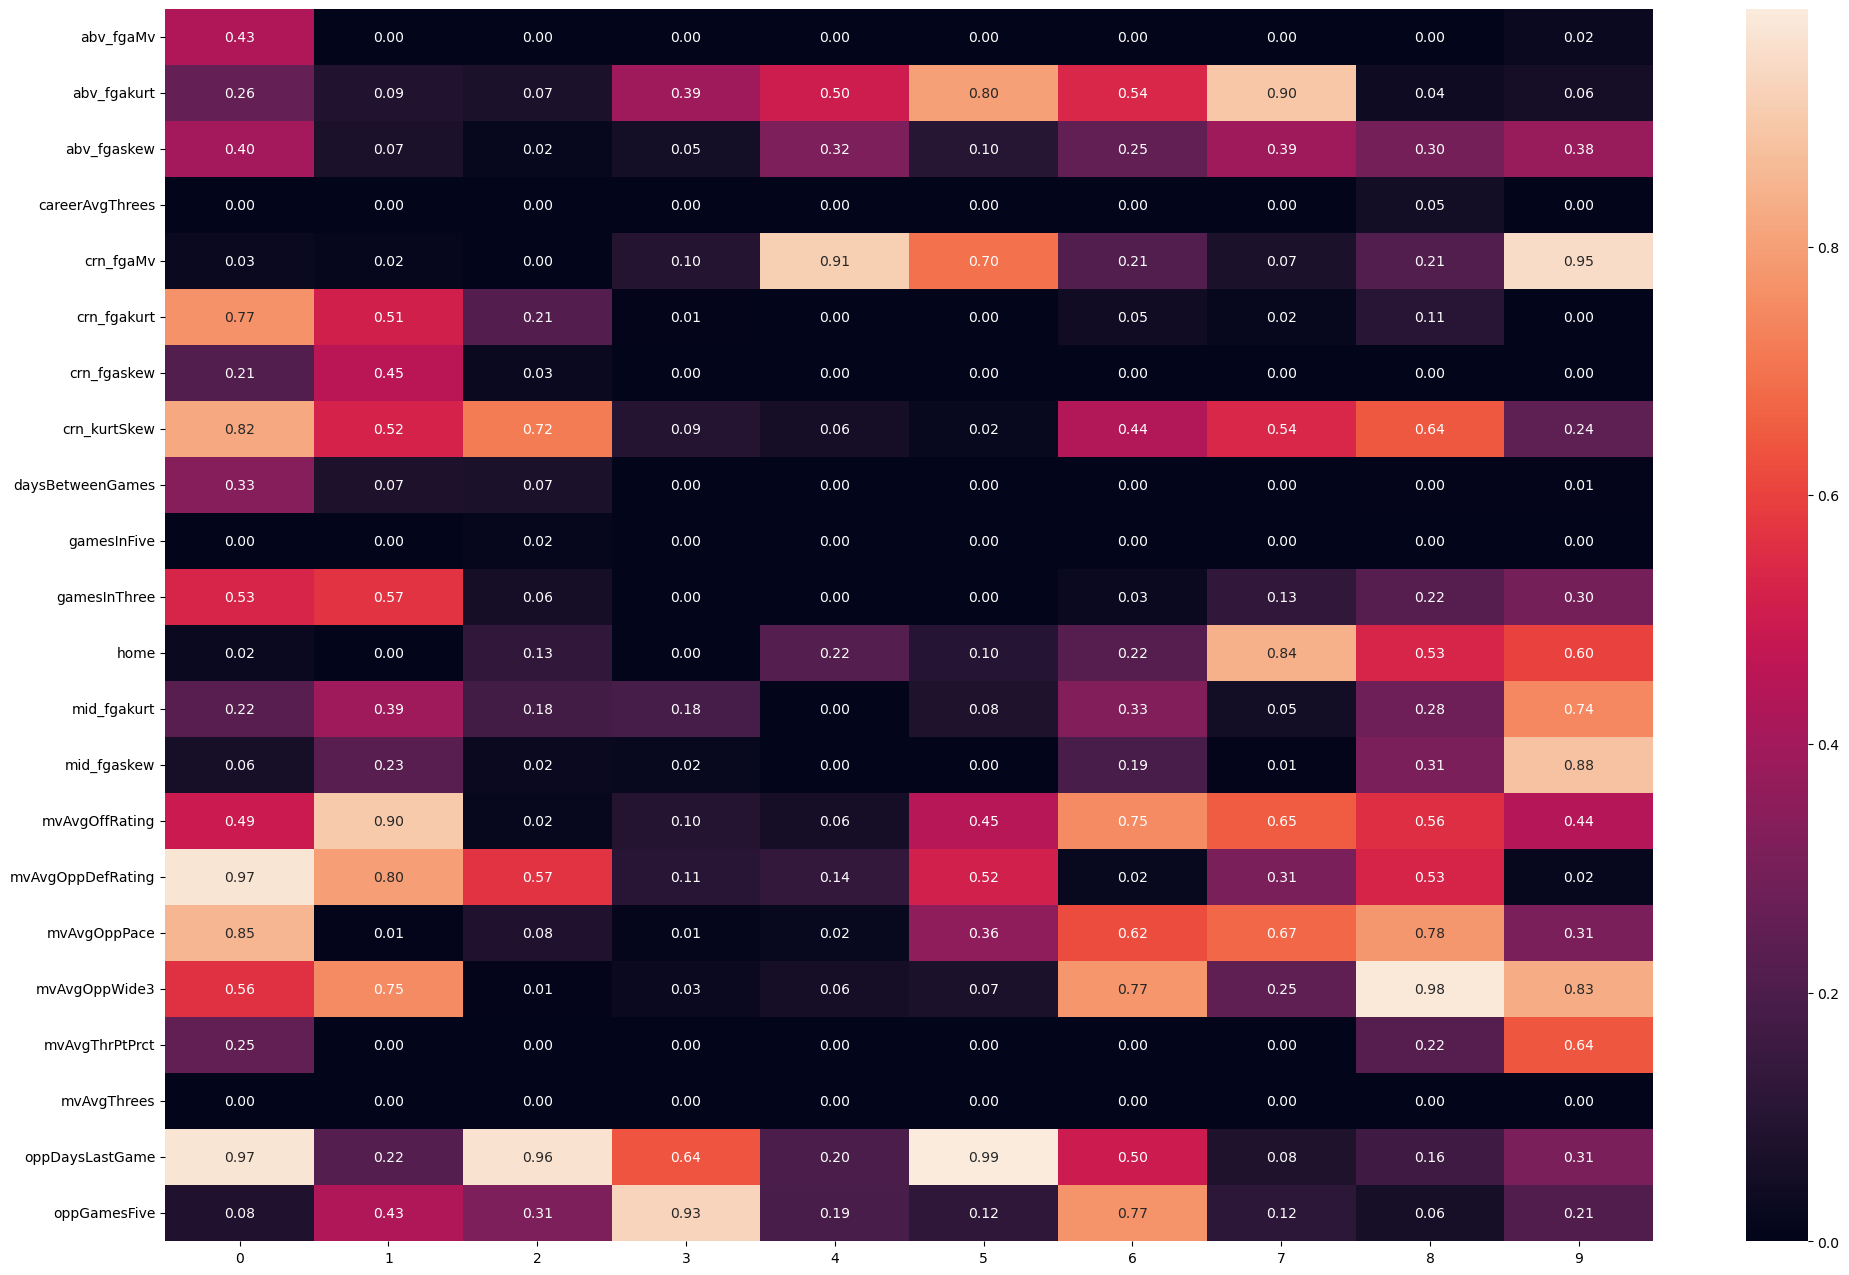

In [268]:
#dropping out paint and ra fields

jumperFeats = [col for col in newFeats if re.search('^paint|ra|mvAvgUsage|fgallowed|^career',col)==None] +['careerAvgThrees']
upMod = modTesting(ybin,yTbin,X,Xtest,jumperFeats,)

Optimization terminated successfully.
         Current function value: 1.710928
         Iterations: 602
         Function evaluations: 604
         Gradient evaluations: 604
cumlative brier score of:  0.701
brier score of:  0.713
Mean Score 0.707
0    0.276
1    0.288
2    0.201
3    0.115
4    0.062
5    0.031
6    0.014
7    0.006
8    0.002
9    0.001
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.002
8    0.005
7    0.011
6    0.025
5    0.056
4    0.118
3    0.234
2    0.435
1    0.724
0    1.000
dtype: float64


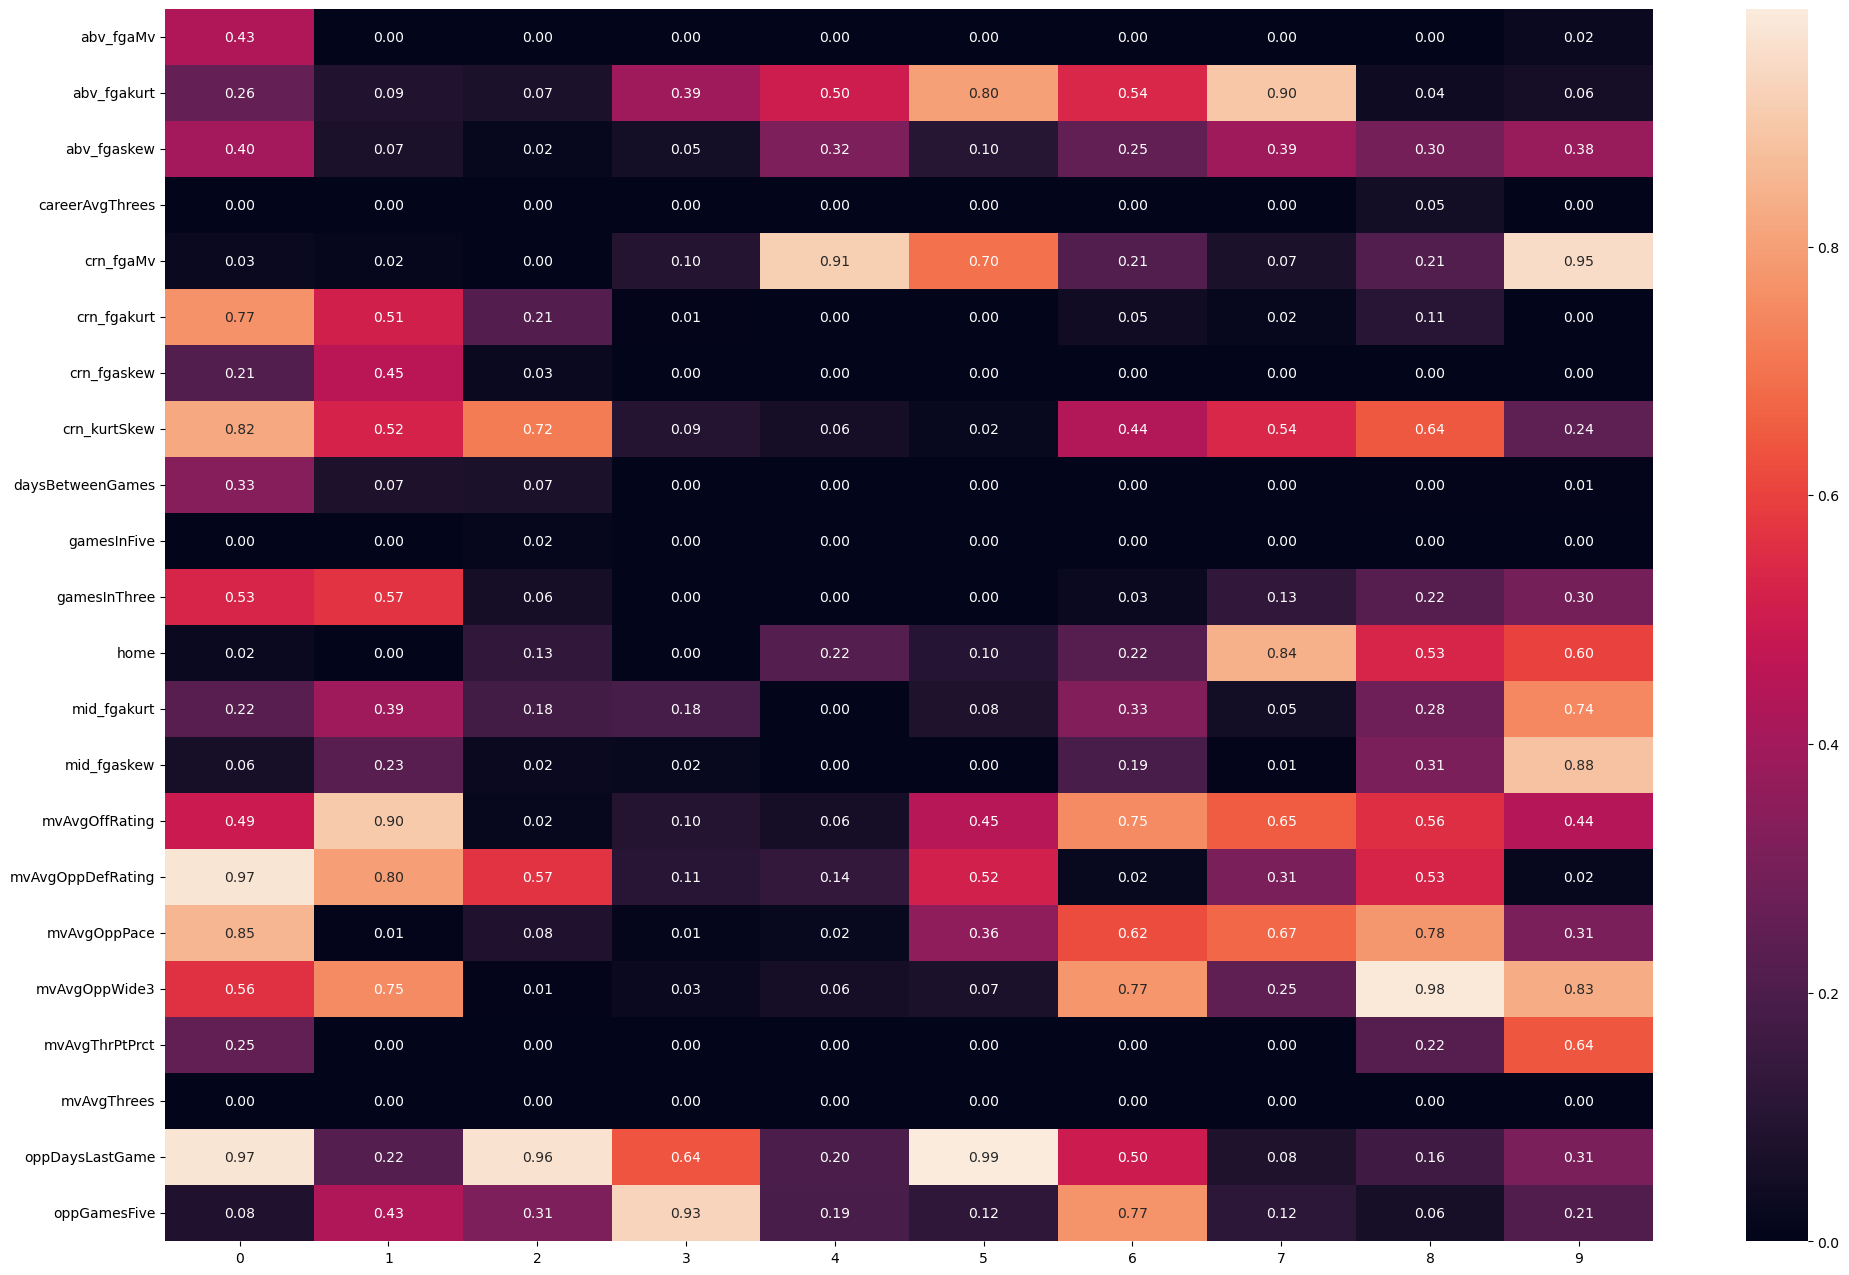

In [563]:
# noCareer = 
upMod = modTesting(ybin,yTbin,X,Xtest,jumperFeats)

In [2100]:
df = nba.threeData('data/sql/thrTesting.sql')
df= df.join(weighted_moving_avg(df,5,15,'crn_fga','player_id'))
df = df.join(weighted_moving_avg(df,5,15,'abv_fga','player_id'))

In [2101]:
d = dt.datetime.today().strftime('%Y-%m-%d')
yst = (pd.to_datetime(d) + pd.to_timedelta(-1,unit='day')).strftime(format='%Y-%m-%d')
td = df[(df.game_date==d) ]

In [2102]:
# dct = {}
# for col in ['crn_fgaMv','abv_fgaMv']:
#     X[col] =ss.fit_transform(X[col].values.reshape(-1,1))
#     dct[col] = {'mean':ss.mean_,'std':ss.var_**.5}

In [2103]:
curYear = df[df.game_date.between('2024-10-01',d)]

In [2104]:
td['abv_kurtSkew'] = td.abv_fgakurt * td.abv_fgaskew
td['crn_kurtSkew'] = td.crn_fgakurt * td.crn_fgaskew
# td = td.join(weighted_moving_avg(td,5,15,'crn_fga','player_id'))
# td = td.join(weighted_moving_avg(td,5,15,'abv_fga','player_id'))

td = nba.cleanNaThr(td)
td = nba.scaleData(td)


In [2105]:
#pMod = pd.read_pickle('data/model/thrModelV2_1.pkl')
p = upMod.predict(td.filter(upMod.params.index.values)).join(td[['name']])


In [206]:
def kellyCrit(prob,odds):
    '''
    Calculates the kelly criterion to help determin betting size, will give as a percentage of bankroll to use
    Inputs: your probability of the event winning, odds (American) that you will be paid out if the win occurs
    Outputs: a float with the amount of your bankroll
    '''
    if odds > 0:
        return prob - (1-prob) / (odds / 100)
    else:
        return prob - (1-prob) / (100/np.abs(odds))
        
def convertPredsToOdds(preds,df):
    c = [10,9,8,7,6,5,4,3,2,1,0]
    finalo = pd.DataFrame(np.array([nba.convertPercentToOdds(v) for r in preds[c].cumsum(axis=1).values for v in r]).reshape(preds[c].shape),
                         columns=c,index=preds.index).drop(0,axis=1)
    overs = df[['name','team']].join(finalo.filter(preds.columns))
    #name matching
    overs['name'] = [x if re.search('[JS]r\.$',x)==None else x[:-1] for x in overs.name]
    return overs
def createFinalFrame(over,odds):
    over = over.melt(id_vars=['name','team',],var_name='threesMade')
    over.threesMade = over.threesMade -.5
    final = odds.merge(over[['name','team','threesMade','value']],how='left',on=['name','threesMade'])
    final = final[final.over_under=='Over']

    final['prob'] = np.where(final.value<0, abs(final.value) / (abs(final.value) + 100), 100/(final.value +100))
    final['DKKelly'] = [kellyCrit(p,odd) / 8 for p,odd in zip(final.prob,final.DraftKings)]
    final['FanDuelKelly'] = [kellyCrit(p,odd) / 8 for p,odd in zip(final.prob,final.FanDuel)]
    final['mgmKelly'] = [kellyCrit(p,odd) / 8 for p,odd in zip(final.prob,final['BetMGM'])]
    final['dkBet'] = [x * 100 * 5 for x in final.DKKelly.values]
    final['fdBet'] = [x * 100 * 5 for x in final.FanDuelKelly.values]
    final['mgmBet'] = [x * 100 * 5 for x in final.mgmKelly]
    return final

In [2107]:
def calc_parlay(d,probs,multipe = 62.5):
    '''
    d: a dictionary that has keys as the player name and the value is the minimum number to be achieved.
    probs: a dataframe that has the columns as the discrete outcomes and the index is the player names
    multiple: budget / kelly value - currently uses eighth kelly and 500 budget
    output: list of each combination (up to 4) for the parlay and the amount to spend. 
    '''
    

In [2108]:
odds  = pd.read_csv('data/csv/{}odds.csv'.format(d))

In [2109]:
overs = convertPredsToOdds(p,td)

In [2110]:
final = createFinalFrame(overs,odds)

In [2090]:
overs[overs.team=='LAC']

,name,team,1,2,3,4,5,6,7,8,9,10
103092,Norman Powell,LAC,-593,-160,170,412,956,2159,4658,9900,9900,9900
103099,Kris Dunn,LAC,-216,196,614,2020,7107,9900,9900,9900,9900,9900
103112,Ivica Zubac,LAC,107,416,1434,4660,9900,9900,9900,9900,9900,9900
103115,Derrick Jones Jr,LAC,-188,203,591,1653,4580,9900,9900,9900,9900,9900
103171,Amir Coffey,LAC,-175,191,512,1519,4356,9900,9900,9900,9900,9900
103367,Nicolas Batum,LAC,-243,172,538,1651,4972,9900,9900,9900,9900,9900
103368,James Harden,LAC,-1053,-275,101,229,537,1251,2876,7979,9900,9900
103377,Kawhi Leonard,LAC,-605,-183,127,263,544,1110,2437,5707,9900,9900
103409,Bogdan Bogdanovic,LAC,-509,-121,236,598,1614,4976,9900,9900,9900,9900


In [359]:
kellyCrit(100/205,220 * 1.5)*62.5

20.787139689578712

In [2111]:
final[final.fdBet>0].sort_values(by='fdBet',ascending=False).head(50)

,name,threesMade,over_under,BetMGM,DraftKings,FanDuel,team,value,prob,DKKelly,FanDuelKelly,mgmKelly,dkBet,fdBet,mgmBet
50,Bogdan Bogdanovic,1.500,Over,105.000,-2.500,-1.000,LAC,-110.000,0.524,0.064,0.065,0.009,31.994,32.440,4.393
412,Nickeil Alexander-Walker,1.500,Over,NaN,-115.000,-1.000,MIN,109.000,0.478,-0.015,0.059,NaN,-7.581,29.578,NaN
506,Stephen Curry,4.500,Over,-140.000,-112.500,-3.000,GSW,154.000,0.394,-0.036,0.047,-0.057,-18.024,23.469,-28.445
206,Jalen Brunson,1.500,Over,NaN,NaN,-129.000,NYK,-231.000,0.698,NaN,0.039,NaN,NaN,19.260,NaN
205,Jalen Brunson,0.500,Over,NaN,NaN,-590.000,NYK,-850.000,0.895,NaN,0.034,NaN,NaN,17.105,NaN
208,Jalen Brunson,2.500,Over,NaN,NaN,240.000,NYK,110.000,0.476,NaN,0.032,NaN,NaN,16.121,NaN
209,Jalen Brunson,3.500,Over,NaN,NaN,600.000,NYK,260.000,0.278,NaN,0.020,NaN,NaN,9.838,NaN
30,Anthony Edwards,3.500,Over,NaN,-145.000,-113.500,MIN,-150.000,0.600,0.003,0.018,NaN,1.250,9.125,NaN
195,Ja Morant,1.500,Over,NaN,NaN,-177.000,MEM,-223.000,0.690,NaN,0.018,NaN,NaN,8.901,NaN
219,Jamal Murray,2.500,Over,145.000,145.000,145.000,DEN,104.000,0.490,0.017,0.017,0.017,8.663,8.663,8.663


In [2041]:
final[((final.FanDuel>350) & (final.fdBet>0)) | ((final.DraftKings>350) & (final.dkBet>0))].sort_values(by='fdBet',ascending=False)

,name,threesMade,over_under,BetMGM,DraftKings,FanDuel,team,value,prob,DKKelly,FanDuelKelly,mgmKelly,dkBet,fdBet,mgmBet
225,Tyrese Haliburton,4.500,Over,450.000,550.000,600.000,IND,300.000,0.250,0.014,0.016,0.010,7.102,7.812,5.208
172,Pascal Siakam,2.500,Over,375.000,450.000,560.000,IND,333.000,0.231,0.008,0.012,0.003,3.753,5.851,1.617
133,Mike Conley,3.500,Over,600.000,700.000,680.000,MIN,422.000,0.192,0.010,0.009,0.007,4.755,4.543,3.552
189,Scotty Pippen Jr,2.500,Over,525.000,NaN,500.000,MEM,342.000,0.226,NaN,0.009,0.010,NaN,4.468,4.929
173,Pascal Siakam,3.500,Over,NaN,1400.000,1400.000,IND,756.000,0.117,0.007,0.007,NaN,3.359,3.359,NaN
226,Tyrese Haliburton,5.500,Over,NaN,1200.000,1200.000,IND,722.000,0.122,0.006,0.006,NaN,3.029,3.029,NaN
184,Santi Aldama,3.500,Over,625.000,NaN,500.000,MEM,388.000,0.205,NaN,0.006,0.010,NaN,2.869,4.857
103,Julius Randle,3.500,Over,800.000,550.000,750.000,MIN,560.000,0.152,-0.000,0.005,0.006,-0.172,2.399,2.841
76,Jaden McDaniels,2.500,Over,600.000,500.000,560.000,MIN,445.000,0.183,0.003,0.005,0.006,1.261,2.355,2.963
202,Tim Hardaway Jr,4.500,Over,775.000,600.000,750.000,DET,566.000,0.150,0.001,0.005,0.005,0.532,2.302,2.531


In [ ]:
# final[final.fdBet>0].sort_values(by='fdBet',ascending=False).head(50)

In [1621]:
#h2h
def h2h(fav,udog,spread=.5,ovrLine = 5.5):
    '''
    Takes in probabilites for player A (prbA) and player B (prbB) and spread between the two, determines the line for the spread and moneyline
    This assumes player A is the favored player
    If over under is enter will also provide the line for that
    input: array of probabilities for two players, spread (ie .05)
    output: text showing probility of player A winning (ml), against the spread and over under
    '''
    ovr= {}
    df = p[p.name.isin([fav,udog])].set_index('name')
    fsp = sum([df.loc[udog][i] * df.loc[fav][np.ceil(i+spread) if i+spread <10 else 10:].sum() for i in range(0,11)])
    usp = sum([df.loc[fav][i] * df.loc[udog][np.ceil(i-spread) if i-spread>0 else 0:].sum() for i in range(0,11)])
    fml = sum([df.loc[fav][i] * df.loc[udog][:i+1].sum() for i in range(0,11)])
    uml = sum([df.loc[udog][i] * df.loc[fav][:i+1].sum() for i in range(0,11)])
    undr = sum([df.loc[fav][i] * df.loc[udog][x]if x==i else df.loc[fav][i] * df.loc[udog][x] + df.loc[fav][x] * df.loc[udog][i]
             for i in np.arange(0,ovrLine) for x in np.arange(0,i+1) if i+x <ovrLine])
    ovr[fav] = {'spreadLine':nba.convertPercentToOdds(fsp),
                'spreadProb':round(fsp,3),
                'ml':nba.convertPercentToOdds(fml),
                'monyProb':round(fml,3)}
    ovr[udog] = {'spreadLine':nba.convertPercentToOdds(usp),
                'spreadProb':round(usp,3),
                'ml':nba.convertPercentToOdds(uml),
                'monyProb':round(uml,3)}
    ovr['over'] = {'underProb':undr,
                   'underMl':nba.convertPercentToOdds(undr),
                   'overProb':1-undr,
                   'overMl':nba.convertPercentToOdds(1-undr),
                  }
    return pd.DataFrame(ovr).T
def bothPlayers(p1,p2,num):
    print('{} to hit {} is {:.2%}'.format(p1,num,p[p.name.isin([p1])].set_index('name')[np.arange(num,11)].sum(axis=1).values[0]))
    print('{} to hit {} is {:.2%}'.format(p2,num,p[p.name.isin([p2])].set_index('name')[np.arange(num,11)].sum(axis=1).values[0]))
    probs = p[p.name.isin([p1,p2])].set_index('name')[np.arange(num,11)].sum(axis=1).prod()
    odds = nba.convertPercentToOdds(probs)
    
    print('Odds: {}, probs: {}'.format(odds,probs))

def eitherPlayer(p1,p2,num):
    print('{} to hit {} is {:.2%}'.format(p1,num,p[p.name.isin([p1])].set_index('name')[np.arange(num,11)].sum(axis=1).values[0]))
    print('{} to hit {} is {:.2%}'.format(p2,num,p[p.name.isin([p2])].set_index('name')[np.arange(num,11)].sum(axis=1).values[0]))
    probs = 1-p[p.name.isin([p1,p2])].set_index('name')[np.arange(0,num)].sum(axis=1).prod()
    odds = nba.convertPercentToOdds(probs)
    print('Odds: {}, probs: {}'.format(odds,probs))

def gameLeader(p,t1,t2):
    p = p.join(overs[['team']])
    

In [1993]:
# bothPlayers('Jordan Poole','Alexandre Sarr',4)
eitherPlayer("Zach LaVine","Michael Porter Jr.",5)

Zach LaVine to hit 5 is 14.21%
Michael Porter Jr. to hit 5 is 17.25%
Odds: 244, probs: 0.29006591673628024


In [2049]:
print(kellyCrit(.644,100) * 62.5)
h2h("Desmond Bane","Naz Reid",spread=.5,ovrLine = 4.5)

18.000000000000004


,spreadLine,spreadProb,ml,monyProb,underProb,underMl,overProb,overMl
Desmond Bane,-106.000,0.517,-211.000,0.680,NaN,NaN,NaN,NaN
Naz Reid,107.000,0.483,107.000,0.483,NaN,NaN,NaN,NaN
over,NaN,NaN,NaN,NaN,0.479,108.000,0.521,-107.000


In [ ]:
p[p.name.isin(['Max Strus','Anfernee Simons'])]

In [1905]:
nba.cur.execute('UPDATE teamLog SET game_date = "2025-03-16" where game_id = "0022400538"')
nba.cur.execute('UPDATE shotsAllowed SET game_date = "2025-03-16" where game_id = "0022400538"')
nba.cur.execute('UPDATE plyrLogs SET game_date = "2025-03-16" where game_id = "0022400538"')

In [1906]:
nba.conn.commit()

In [1904]:
pd.read_sql('select * from teamLog where game_date = "2025-01-11"',nba.conn)

,game_id,game_date,team_id,inactive,count_inactive,assist_pct,off_rate,def_rate,pace,possessions,...,q1_pts,q2_pts,q3_pts,q4_pts,ot1_pts,ot2_pts,ot3_pts,ot4_pts,win,season
0,0022400538,2025-01-11,1610612746,None,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,None,None,None,NaN,2024-25
1,0022400538,2025-01-11,1610612766,None,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,None,None,None,NaN,2024-25
2,0022400536,2025-01-11,1610612757,"203924,1629057,1631386",3.000,0.667,101.000,122.700,97.000,97.000,...,23.000,25.000,35.000,15.000,None,None,None,None,1.000,2024-25
3,0022400536,2025-01-11,1610612748,"1641815,1630696",2.000,0.705,122.700,101.000,97.000,97.000,...,29.000,37.000,28.000,25.000,None,None,None,None,0.000,2024-25
4,0022400534,2025-01-11,1610612765,"1631199,1642449,1641752,1642450,1631093",5.000,0.795,123.000,114.000,100.000,100.000,...,32.000,33.000,34.000,24.000,None,None,None,None,1.000,2024-25
5,0022400534,2025-01-11,1610612761,"1630639,1630647,1642419,1642279,1642367",5.000,0.675,114.000,123.000,100.000,100.000,...,32.000,34.000,27.000,21.000,None,None,None,None,0.000,2024-25
6,0022400533,2025-01-11,1610612756,"1626220,1641779,1631102,1631221",4.000,0.591,121.300,112.800,94.000,94.000,...,31.000,34.000,22.000,27.000,None,None,None,None,1.000,2024-25
7,0022400533,2025-01-11,1610612762,"203903,1630548,1641729,1628381,1641718,1641707",6.000,0.619,112.800,121.300,94.000,94.000,...,27.000,27.000,25.000,27.000,None,None,None,None,0.000,2024-25
8,0022400535,2025-01-11,1610612750,"1630545,1642399,1642265,1641803",4.000,0.787,122.500,124.500,102.000,102.000,...,33.000,32.000,38.000,22.000,None,None,None,None,0.000,2024-25
9,0022400535,2025-01-11,1610612763,"1642389,1641713,203935,1642285,1631246",5.000,0.521,124.500,122.500,102.000,102.000,...,35.000,29.000,35.000,28.000,None,None,None,None,1.000,2024-25


In [1320]:
tst = p[p.name.isin(['Zach LaVine',"Karl-Anthony Towns"])].set_index('name')
fav,udog = ['Zach LaVine',"Karl-Anthony Towns"]
ovrLine = 4.5

In [1327]:
ovrLine

4.5

In [1379]:
[(x,i) for i in range(0,int(ovrLine)+1) for x in range(0,i+1) if i+x <ovrLine]

[(0, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 1, 1, 1),
 (2, 0, 0, 2),
 (2, 1, 1, 2),
 (2, 2, 2, 2),
 (3, 0, 0, 3),
 (3, 1, 1, 3),
 (4, 0, 0, 4)]

[(0.016140905119060068, 0.0, 0.0),
 (0.0454271957948785, 0.025825589504816827, 0.0, 1.0),
 (0.07268391098886474, 1.0, 1.0),
 (0.05003855751471719, 0.021068941236469695, 0.0, 2.0),
 (0.08006213011327747, 0.05929673160705831, 1.0, 2.0),
 (0.06531600427973262, 2.0, 2.0),
 (0.03464589969009997, 0.012361683807252763, 0.0, 3.0),
 (0.05543374283050655, 0.03479090091443097, 1.0, 3.0),
 (0.02405793675183268, 0.004376254362395576, 0.0, 4.0)]

In [ ]:
### bill's regression code to work through
## assume we have 6 features
## we make a fake increasing "b"
b = np.arange(0, 6, 1).reshape(-1,1) ## forces linear and increasing
print(b)
## x represents our actual data in that observation
x = np.random.rand(6)
print('x = ',x)
## give it a constant
xb = np.concatenate([np.ones(b.shape), x.reshape(-1,1)], axis=1)
print('\nxb =',xb)
## run the regression and you can use each item
intSlope, residual, rank, s = np.linalg.lstsq(b, xb, rcond=None)
print('\nintercept:\t{:.4f}\nslope\t{:.4f}\nresid:\t{}\ns:\t{:.4f}'.format(*intSlope.flatten(),np.array2string(residual),s[0]))

In [ ]:
saData = nba.update_shots_allowed(games[games.ra_fga.isna()].game_date.unique())

In [ ]:
#lets look at some data from this year
today = dt.datetime.today().strftime(format='%Y-%m-%d')
yst = (pd.to_datetime(today) + pd.to_timedelta(-1,unit='day')).strftime(format='%Y-%m-%d')
pdf = pd.read_sql('''select name,pl.*,abv_fgm + lc_fgm + rc_fgm as ThreesMade,abv_fga + lc_fga + rc_fga as ThreesAtts
                    from plyrLogs pl left join players p on pl.player_id = p.player_id 
                    where game_date between '2024-10-01' and '{}' '''.format(yst),nba.conn)

In [ ]:
sns.histplot(pdf.ThreesAtts,binwidth=1)
plt.show()

In [ ]:
mnThrees = pdf.groupby(['player_id']).ThreesAtts.mean().dropna().values

In [ ]:
sns.histplot(pdf.groupby('player_id').ThreesAtts.mean())
plt.vlines(x = pdf.groupby(['player_id']).ThreesAtts.mean().quantile([.25,.5,.75,.8,.9]).values,ymin=0,ymax=100,color='red',linestyles='--')
plt.show()

In [ ]:
sns.histplot(pdf.groupby('player_id').ThreesMade.mean())
plt.vlines(x = pdf.groupby(['player_id']).ThreesMade.mean().quantile([.25,.5,.75,.8,.9]).values,ymin=0,ymax=100,color='red',linestyles='--')
plt.show()

In [ ]:
pdf.groupby(['player_id']).ThreesAtts.mean().quantile([.9])

In [ ]:
pdf[(pdf.groupby(['player_id']).ThreesAtts.transform('mean')>3)].player_id.nunique()

In [ ]:
pdf[pdf.groupby('player_id').ThreesAtts.transform('mean')>6.5].player_id.nunique()

In [ ]:
sns.histplot(((pdf.lc_fga + pdf.rc_fga) / pdf.ThreesAtts).fillna(0))
plt.vlines(((pdf.lc_fga + pdf.rc_fga) / pdf.ThreesAtts).fillna(0).quantile([.2,.4,.6,.8]),color='red',linestyle='--',ymin=0,ymax=2500)
plt.show()

In [ ]:
((pdf.lc_fga + pdf.rc_fga) / pdf.ThreesAtts).fillna(0).quantile([.2,.4,.6,.8])

In [ ]:
pdf.ThreesAtts.quantile([.2,.4,.5,.6,.8])

In [ ]:
today = dt.datetime.today().strftime('%Y-%m-%d')
gids = nba.get_games('{}-10-01'.format('2024'),today)
season = nba.get_schedule('2024')

In [535]:
## updating teamlog
def update_schedule(adds):
    '''Give a data frame with the game_date, game_id, team_id and home
    '''
    tcols = pd.read_sql('select * from teamLog limit 1',nba.conn).columns
    #adds = season[(~season.game_id.isin(gids.GAME_ID)) & (season.game_date<=today)]
    for col in tcols:
        if col not in adds.columns:
            adds[col] = None
    nba.insert_data(adds.filter(tcols),'teamLog')
    #updating playerlogs
    pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
    plyrs = pd.read_sql("select teamId as team_id, playerId as player_id from rosters where endDate is Null ",nba.conn)
    df = adds.merge(plyrs,how='left',on=['team_id'])
    for col in pcols:
        if col not in df:
            df[col] = None
    nba.insert_data(df.filter(pcols),'plyrLogs')
    #updating shotsallowed
    saCols = pd.read_sql('select * from shotsAllowed limit 1',nba.conn).columns
    #sadf = season[(~season.game_date.isin(saGames)) & (season.game_date<=today)]
    for col in saCols:
        if col not in adds:
            adds[col] = 0
    nba.insert_data(adds.filter(saCols),'shotsAllowed')

In [537]:
adds = pd.read_sql('select game_date,game_id,team_id, home from teamLog where game_date ="2025-02-19"',nba.conn)
pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
plyrs = pd.read_sql("select teamId as team_id, playerId as player_id from rosters where endDate is Null ",nba.conn)
df = adds.merge(plyrs,how='left',on=['team_id'])
for col in pcols:
    if col not in df:
        df[col] = None
nba.insert_data(df.filter(pcols),'plyrLogs')

plyrLogs has been updated with 34 rows


In [ ]:

pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
plyrs = pd.read_sql("select teamId as team_id, playerId as player_id from rosters where endDate is Null ",nba.conn)
df = adds.merge(plyrs,how='left',on=['team_id'])
for col in pcols:
    if col not in df:
        df[col] = None
nba.insert_data(df.filter(pcols),'plyrLogs')

In [ ]:
adds = pd.DataFrame([['2025-01-28','0022400660','1610612747',0]],columns = ['game_date','game_id','team_id','home'])

In [ ]:
adds = nba.get_games('2024-10-01','2025-03-30')

In [ ]:
adds.GAME_DATE.max()

In [ ]:
nba.conn.execute("DELETE FROM teamLog where game_id = '0022400537' ")
nba.conn.execute("DELETE FROM shotsAllowed where game_id = '0022400537'")
nba.conn.execute("DELETE FROM plyrLogs where game_id = '0022400537'")
nba.conn.commit()

In [ ]:
update_schedule(adds)

In [ ]:
df = season[(~season.game_id.isin(gids.GAME_ID)) &(season.game_date<=today)]
saCols = pd.read_sql('select * from shotsAllowed limit 1',nba.conn).columns
saGames = pd.read_sql("select * from shotsAllowed where game_date > '2024-10-01'",nba.conn).game_date.unique()
sadf = season[(~season.game_date.isin(saGames)) & (season.game_date<=today)]
for col in saCols:
    if col not in sadf:
        sadf[col] = 0
nba.insert_data(sadf.filter(saCols),'shotsAllowed')

In [ ]:
def change_games(gid,newDate):
    nba.conn.execute("UPDATE teamLog SET game_date = '{}'  WHERE game_id = '{}'".format(newDate,gid))
    nba.conn.execute("UPDATE plyrLogs SET game_date = '{}' WHERE game_id = '{}'".format(newDate,gid))
    nba.conn.execute("UPDATE shotsAllowed SET game_date = '{}' WHERE game_id = '{}'".format(newDate,gid))
    nba.conn.commit()
    print('Game updated')


In [ ]:
pd.read_sql("select * from teams where teamAbrv in('HOU','ATL')",nba.conn)

In [ ]:
season = nba.get_schedule(year)
tcols = pd.read_sql('select * from teamLog limit 1',nba.conn).columns
adds = season[~season.game_id.isin(gids.game_id)]
for col in tcols:
    if col not in adds.columns:
        adds[col] = None
nba.insert_data(adds.filter(tcols),'teamLog')
#updating playerlogs
pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
plyrs = pd.read_sql("select teamId as team_id, playerId as player_id from rosters where endDate is Null ",nba.conn)
df = adds.merge(plyrs,how='left',on=['team_id'])
for col in pcols:
    if col not in df:
        df[col] = None
nba.insert_data(df.filter(pcols),'plyrLogs')
#updating shotsallowed
df = season[~season.game_id.isin(gids.game_id)]

In [593]:
### TRADE HAPPENED! 
nba.cur.execute("select * from roster_view where name in ('Anthony Davis','Luka Doncic','Max Christie', 'Maxi Kleber')").fetchall()

[('Max Christie', '1631108', 'LAL', '1610612747'),
 ('Anthony Davis', '203076', 'LAL', '1610612747'),
 ('Luka Doncic', '1629029', 'DAL', '1610612742'),
 ('Maxi Kleber', '1628467', 'DAL', '1610612742')]

In [594]:
tdf = pd.read_sql("select * from roster_view where name in ('Anthony Davis','Luka Doncic','Max Christie', 'Maxi Kleber')",nba.conn)
tdf['newTeam'] = [tdf.team_id.unique()[tdf.team_id.unique()!=x][0] for x in tdf.team_id]
tdf['tradeDate'] = "2025-02-02"

In [726]:
tdf.player_id.values

array(['1631108', '203076', '1629029', '1628467'], dtype=object)

In [ ]:
pd.read_sql('select * from teams',nba.conn)

In [ ]:
tdf = pd.read_sql('''select * from roster_view where name in ("Caris LeVert",
"Georges Niang", "De\'Andre Hunter", "Jimmy Butler", "Andrew Wiggins", "Dennis Schroder","Terance Mann","Bones Hyland",
"Bogdan Bogdanovic","Jusuf Nurkic","Vasilije Micic","Cody Martin","Dalton Knecht","Davion Mitchell","Kyle Anderson","KJ Martin",
"Cam Reddish","Josh Richardson","Bruce Brown","Kelly Olynyk","Khris Middleton","Kyle Kuzma",
"AJ Johnson","Patrick Baldwin Jr","Quentin Grimes","Caleb Martin")''',nba.conn)

In [ ]:
tdf['newTeam'] = [1610612758,1610612741,1610612759,1610612741,1610612741,1610612758,1610612759]
tdf['tradeDate'] = '2025-02-02'

In [ ]:
t

In [ ]:
tdf['newTeam'] = [1610612748,1610612746,1610612740,1610612744,1610612755,1610612739,1610612737,
 1610612764,1610612766,1610612749,1610612737,1610612737,1610612742,1610612756,1610612762,
 1610612756,1610612764,1610612748, 1610612737,1610612766,1610612740,1610612766,0,1610612748,1610612765]

In [ ]:
tdf.replace(0,1610612762,inplace=True)

In [ ]:
tdf['tradeDate'] = '2025-02-05'

In [1137]:
# d['teamId'] = '1610612744'
# d['startDate'] = '2024-12-16'
# d['endDate'] = None
# nba.insert_data(d,'rosters')
#remove player's upcoming schedule
def trade_update(df):
    '''dataframe with player_id,name, trade_date and new_team.
    Will update rosters with the new players and print out a statement stating how many rows have been changed for each player
    Inputs: dataframe
    Output: None, print statement for update
    '''
    date = df.tradeDate.unique()[0]
    pids = ','.join(df.player_id.unique())
    nba.cur.execute("DELETE FROM plyrLogs WHERE player_id in ({})  and game_date >= '{}' ".format(pids,date))
    nba.conn.commit()
    #update player's schedule with new team
    lst = df.filter(['player_id','newTeam','tradeDate']).values
    for l in lst:
        q ="select '{}' as player_id,team_id,game_date,game_id from teamLog where team_id = '{}' and game_date > '{}'".format(*l)
        new = pd.read_sql(q,nba.conn)
        pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
        for col in pcols:
            if col not in new.columns:
                new[col] = None
        nba.insert_data(new.filter(pcols),'plyrLogs')

In [1138]:
trade_update(chk)

plyrLogs has been updated with 20 rows


In [370]:
g24 = [date+"T12:00:00Z" for date in nba.get_games("2024-10-01",yst).GAME_DATE.unique()]


In [19]:
def histEvents(sport,date):
    '''ISO Formatted dates for today and tomorrow returns the games that will be played today ids for odds pulls
    Inputs: sport that you are looking up and ISO formatted date for the values
    Output: list of game ids
    '''
    #getting the key will be done in the module
    dct = json.loads(open('config.json','r').read())
    key = dct.get('oddsApi').get('paid')
    #####
    histURL = 'https://api.the-odds-api.com/v4/historical/sports/{}/events?apiKey={}&dateFormat=iso&date={}T12:00:00Z'

    r = requests.get(histURL.format(sport,key,date))
    return r,key


#games,key= histOddsData('basketball_nba',g24[1])

In [15]:
histURL = 'https://api.the-odds-api.com/v4/historical/sports/{}/events?apiKey={}&dateFormat=iso&date={}'
r = requests.get(histURL.format('basketball_nba',date))

NameError: name 'key' is not defined

In [200]:
days = nba.get_games('2023-10-01','2025-03-27').GAME_DATE.unique()

In [28]:
import pickle

In [300]:
data,key = histEvents('basketball_nba','2023-10-25')

In [302]:
data.json()

{'timestamp': '2023-10-25T11:55:43Z',
 'previous_timestamp': '2023-10-25T11:50:43Z',
 'next_timestamp': '2023-10-25T12:00:43Z',
 'data': [{'id': 'be1ee8db7ba20de87a087e8851f9b2f5',
   'sport_key': 'basketball_nba',
   'sport_title': 'NBA',
   'commence_time': '2023-10-25T23:00:00Z',
   'home_team': 'Charlotte Hornets',
   'away_team': 'Atlanta Hawks'},
  {'id': '866b0f885ae4bebcabf5a6d57eb4064a',
   'sport_key': 'basketball_nba',
   'sport_title': 'NBA',
   'commence_time': '2023-10-25T23:00:00Z',
   'home_team': 'New York Knicks',
   'away_team': 'Boston Celtics'},
  {'id': '13898382e266df26f137ea596fd51666',
   'sport_key': 'basketball_nba',
   'sport_title': 'NBA',
   'commence_time': '2023-10-25T23:00:00Z',
   'home_team': 'Orlando Magic',
   'away_team': 'Houston Rockets'},
  {'id': '27ba27b22fe22e75d917a4bf9c7d0b1c',
   'sport_key': 'basketball_nba',
   'sport_title': 'NBA',
   'commence_time': '2023-10-25T23:00:00Z',
   'home_team': 'Indiana Pacers',
   'away_team': 'Washington 

In [378]:
##will have to pull in the above and do the following for first baskets
lkups = 'player_threes_alternate,player_points_alternate,player_first_basket,player_first_team_basket'
primeMarkets = 'https://api.the-odds-api.com/v4/historical/sports/{}/odds/?apiKey={}&regions=us&markets={}&oddsFormat=american&date={}'
altMarkets = 'https://api.the-odds-api.com/v4/historical/sports/{}/events/{}/odds?apiKey={}&regions=us&oddsFormat=american&bookmakers={}&markets={}&date={}'
books = 'draftkings%2Cfanduel%2cbetmgm%cespnbet'
final = {}
lstSeason= None
missing = []
for ct,date in enumerate(tqdm(days)):
    
    season = nba.derive_season(date)

    if season != lstSeason and lstSeason is not None:
        with open('data/pickle/{}gameLines.pkl'.format(lstSeason),'wb') as f:
            pickle.dump(final,f)
        print('{} has been saved as pickle file'.format(lstSeason))
        print('{:,.0f} Requests Remaining'.format(float(data.headers.get('X-Requests-Remaining'))))
        time.sleep(90)
        final = {}
    data,key = histEvents('basketball_nba',date)
    gs = 0

    for dct in data.json().get('data'):
        #1hr before tip
        gTime = (dt.datetime.fromisoformat(dct.get('commence_time')) - dt.timedelta(hours=1)).strftime('%Y-%m-%dT%H:%M:00Z')
        pull =  requests.get(altMarkets.format('basketball_nba',dct.get('id'),key,books,'h2h,spreads,totals',gTime))
        final.update({'{}_{}'.format(ct,gs):pull.json().get('data')})
        gs +=1
    lstSeason = season
    if np.random.randint(1,100) % 5 == 0:
        time.sleep(np.random.randint(1,6))
with open('data/pickle/{}q1.pkl'.format(lstSeason),'wb') as f:
    pickle.dump(final,f)


 48%|██████████████████▋                    | 147/307 [28:07<1:19:35, 29.85s/it]

2024-25 has been saved as pickle file
4,492,021 Requests Remaining


100%|█████████████████████████████████████████| 307/307 [49:37<00:00,  9.70s/it]


In [322]:
##get dictionary to load into database

In [407]:
kellyCrit(100/526,750*1.3) * 2100/8

28.100321731500433

In [379]:
with open('data/pickle/{}gameLines.pkl'.format(lstSeason),'wb') as f:
    pickle.dump(final,f)

In [349]:
import glob
dct = glob.glob('data/pickle/*point*.pkl')

In [352]:
chk = pd.read_pickle(dct[0])

In [259]:
d = pd.read_pickle(PtThr[2])


In [267]:
pd.DataFrame([[d.get('147_0').get('commence_time')[:10],d.get('147_0').get('home_team'),1],
[d.get('147_0').get('commence_time')[:10],d.get('147_0').get('away_team'),0]])

,0,1,2
0,2024-04-14,Indiana Pacers,1
1,2024-04-14,Atlanta Hawks,0


In [289]:
df = pd.DataFrame(columns = ['date','team','home','key'])
notAdded = []
for key in d.keys():
    try:
        df= pd.concat([df,pd.DataFrame([[d.get(key).get('commence_time')[:10],d.get(key).get('home_team'),1,key],
    [d.get(key).get('commence_time')[:10],d.get(key).get('away_team'),0,key]],columns = ['date','team','home','key'])])
    except:
        notAdded.append(key)

In [303]:
df[(df.date=='2023-10-25') & (df.team=='Atlanta Hawks')]

,date,team,home,key
1,2023-10-25,Atlanta Hawks,0,305_0
1,2023-10-25,Atlanta Hawks,0,306_2


In [182]:
'{:%Y}-{:%y}'.format(pd.to_datetime(date) -  pd.to_timedelta(365,'days'),pd.to_datetime(date))

'2023-24'

In [433]:
kellyCrit(100/440,450*1.3) * 2500 / 8

29.74456099456099

In [30]:
pickle.dump(dct,open('data/pickle/{}firstBaskets.pkl'.format(season),'wb'))

In [1104]:
r,k = histEvents('basketball_nba','2024-04-14')

In [434]:
nba.teams

,team_id,teamAbrv
0,1610612737,ATL
1,1610612738,BOS
2,1610612739,CLE
3,1610612740,NOP
4,1610612741,CHI
5,1610612742,DAL
6,1610612743,DEN
7,1610612744,GSW
8,1610612745,HOU
9,1610612746,LAC


In [524]:
pd.read_sql('''SELECT team_id, game_id, sum(dreb) as dreb,
sum(dreb_contest) dreb_contest,
sum(dreb_chances) dreb_chances,
sum(dreb_chance_defer) dreb_chance_defer,
sum(oreb) as oreb,
sum(oreb_contest) oreb_contest,
sum(oreb_chances) oreb_chances,
sum(oreb_chance_defer) oreb_chance_defer
FROM plyrLogs

WHERE team_id in (1610612743,1610612747)
AND game_date = '2025-03-19'
GROUP BY team_id,game_id
''',nba.conn)

,team_id,game_id,dreb,dreb_contest,dreb_chances,dreb_chance_defer,oreb,oreb_contest,oreb_chances,oreb_chance_defer
0,1610612743,0022401006,33,11,49,5,12,10,29,1
1,1610612747,0022401006,30,8,53,4,8,4,23,1


In [522]:
updates = pd.read_sql("select distinct game_date,game_id from plyrLogs WHERE game_id in (select distinct game_id from plyrLogs group by game_id having sum(dreb)=0) and game_date > '2021-10-01' ",nba.conn)

In [523]:
cols =['OREB','OREB_CONTEST','OREB_CHANCES','OREB_CHANCE_DEFER','AVG_OREB_DIST','DREB','DREB_CONTEST','DREB_CHANCES','DREB_CHANCE_DEFER','AVG_DREB_DIST','PLAYER_ID','GAME_ID']
for d in updates.game_date.unique():
    temp = nba.get_rebounds([d])[cols]
    nba.cur.executemany('''
UPDATE plyrLogs SET oreb = ?, oreb_contest = ?, oreb_chances = ?, oreb_chance_defer = ?, avg_oreb_dist = ?, dreb = ?, dreb_contest = ?,
dreb_chances = ?, dreb_chance_defer = ?, avg_dreb_dist = ? WHERE player_id = ? AND game_id = ?
''',temp.values.tolist())

started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:09
started rebounds at 07:09
ended rebounds at 07:10
started rebounds at 07:10
ended rebounds at 07:10
started rebounds at 07:10
ended rebounds at 07:10
started rebounds at 07:10
ended rebounds at 07:10
started rebounds at 07:10
ended rebounds at 07:10
started rebounds at 07:10
ended rebounds at 07:10
started rebounds at 07:10
ended rebounds at 07:10
started rebounds at 07:10
ended rebounds at 07:10


In [480]:
updates['mnth'] = updates.game_date.apply(lambda x:x[:7])

In [511]:
temp

,OREB,OREB_CONTEST,OREB_CHANCES,OREB_CHANCE_DEFER,AVG_OREB_DIST,PLAYER_ID,GAME_ID
0,0,0,0,0,0.000,1631260,0022400052
1,0,0,0,0,0.000,1642358,0022400051
2,0,0,3,0,0.000,203932,0022400058
3,0,0,1,0,0.000,1628988,0022400059
4,2,2,4,0,3.000,1630598,0022400055
...,...,...,...,...,...,...,...
204,3,3,4,0,6.100,1641705,0022400057
205,5,4,9,0,2.500,1631117,0022400055
206,2,2,4,0,2.100,1628976,0022400053
207,0,0,0,0,0.000,1631111,0022400050


In [533]:
kellyCrit(100/555,575) * 2500/8

11.7508813160987

In [462]:
rbs[rbs.TEAM_ID == 1610612743][['PLAYER_ID','GAME_ID','OREB','OREB_CONTEST','OREB_CHANCES','OREB_CHANCE_DEFER','AVG_OREB_DIST']]

,PLAYER_ID,GAME_ID,OREB,OREB_CONTEST,OREB_CHANCES,OREB_CHANCE_DEFER,AVG_OREB_DIST
1,203932,0022401006,1,1,3,0,2.900
31,1631128,0022401006,0,0,0,0,0.000
70,1641816,0022401006,1,1,1,0,18.700
82,1629618,0022401006,1,0,2,0,8.900
138,1629008,0022401006,2,2,3,0,2.400
155,1641790,0022401006,1,1,2,0,3.900
159,1631212,0022401006,1,1,2,0,2.800
166,201566,0022401006,3,2,6,0,3.700
177,1642461,0022401006,2,2,6,1,11.700
194,1628427,0022401006,0,0,0,0,0.000


In [460]:
pd.read_sql("select player_id,game_id, oreb,dreb from plyrLogs where team_id = 1610612743 and game_date = '2025-03-19'",nba.conn)

,player_id,game_id,oreb,dreb
0,1641790,0022401006,0,0
1,1628427,0022401006,0,0
2,1642461,0022401006,0,0
3,1631128,0022401006,0,0
4,1631212,0022401006,0,0
5,1630192,0022401006,0,0
6,1641816,0022401006,0,0
7,203932,0022401006,0,0
8,1629618,0022401006,0,0
9,1629008,0022401006,0,0


array(['2022-11-25', '2024-12-03', '2024-10-23', '2024-10-24',
       '2024-10-27', '2024-10-29', '2024-10-31', '2024-11-02',
       '2024-11-03', '2024-11-07', '2024-11-09', '2024-11-25',
       '2024-11-30', '2024-12-05', '2024-12-07', '2024-12-09',
       '2024-12-20', '2024-12-26', '2024-12-27', '2024-12-30',
       '2025-01-01', '2025-01-04', '2025-01-08', '2025-01-09',
       '2025-01-11', '2025-03-17', '2025-03-16', '2025-01-12',
       '2025-01-14', '2025-01-16', '2025-01-18', '2025-01-20',
       '2025-04-06', '2025-03-19', '2025-01-26', '2025-01-29',
       '2025-01-31', '2025-02-02', '2025-02-03', '2025-02-05',
       '2025-02-09', '2025-02-11', '2025-02-13', '2025-02-21',
       '2025-02-23', '2025-02-24', '2025-02-26', '2025-03-01',
       '2025-03-03', '2025-03-07', '2025-03-08', '2025-03-09',
       '2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13',
       '2025-03-14', '2025-04-01', '2025-03-18', '2025-03-20',
       '2025-03-22', '2025-03-23', '2025-03-24', '2025-

In [1099]:
gTime = (dt.datetime.fromisoformat(dct.get('commence_time')) - dt.timedelta(hours=1)).strftime('%Y-%m-%dT%H:%M:00Z')
pull =  requests.get(altMarkets.format('basketball_nba',dct.get('id'),key,books,'player_first_basket,player_first_team_basket',gTime))
final.update({'{}_{}'.format(ct,gs):pull.json().get('data')})
gs +=1
lstSeason = se

['2024-04-14',
 '2024-04-12',
 '2024-04-11',
 '2024-04-10',
 '2024-04-09',
 '2024-04-07',
 '2024-04-06',
 '2024-04-05',
 '2024-04-04',
 '2024-04-03',
 '2024-04-02',
 '2024-04-01',
 '2024-03-31',
 '2024-03-30',
 '2024-03-29',
 '2024-03-28',
 '2024-03-27',
 '2024-03-26',
 '2024-03-25',
 '2024-03-24',
 '2024-03-23',
 '2024-03-22',
 '2024-03-21',
 '2024-03-20',
 '2024-03-19',
 '2024-03-18',
 '2024-03-17',
 '2024-03-16',
 '2024-03-15',
 '2024-03-14',
 '2024-03-13',
 '2024-03-12',
 '2024-03-11',
 '2024-03-10',
 '2024-03-09',
 '2024-03-08',
 '2024-03-07',
 '2024-03-06',
 '2024-03-05',
 '2024-03-04',
 '2024-03-03',
 '2024-03-02',
 '2024-03-01',
 '2024-02-29',
 '2024-02-28',
 '2024-02-27',
 '2024-02-26',
 '2024-02-25',
 '2024-02-24',
 '2024-02-23',
 '2024-02-22',
 '2024-02-15',
 '2024-02-14',
 '2024-02-13',
 '2024-02-12',
 '2024-02-11',
 '2024-02-10',
 '2024-02-09',
 '2024-02-08',
 '2024-02-07',
 '2024-02-06',
 '2024-02-05',
 '2024-02-04',
 '2024-02-03',
 '2024-02-02',
 '2024-02-01',
 '2024-01-

In [1054]:
import time

In [1661]:
markets = 'player_threes_alternate,player_points_alternate,player_first_basket,player_first_team_basket'
primeMarkets = 'https://api.the-odds-api.com/v4/historical/sports/{}/odds/?apiKey={}&regions=us&markets={}&oddsFormat=american&date={}T12:00:00Z'
altMarkets = 'https://api.the-odds-api.com/v4/historical/sports/{}/events/{}/odds?apiKey={}&regions=us&markets={}&dateFormat=iso&bookmakers=betmgm%2Cfanduel%2Cdraftkings%2Cespnbet&oddsFormat=american&date={}'
odds = requests.get(altMarkets.format('basketball_nba','ec83fa537e65517332af6c966ae6fba4'
                ,key,'player_points_alternate','2025-03-21T01:40:00Z'))

In [496]:
pts = odds.json().get('data').get('bookmakers')

In [480]:
fb = odds.json().get('data').get('bookmakers')

In [635]:
final = pd.DataFrame()
for book in fb:
    for market in book.get('markets'):
        print(book.get('title'))
        mrkt = market.get('key')
        temp = pd.DataFrame(market.get('outcomes'))
        temp['market']= mrkt
        temp['date'] = date[:date.find('T')]

        final = pd.concat([final,temp])

DraftKings
Fanatics
FanDuel
FanDuel
Caesars


In [ ]:
##### historical information
bkmkrs = 'draftkings%2Cfanduel%Bet'
pull = 'https://api.the-odds-api.com/v4/historical/sports/{}/odds/?apiKey={}&regions=us&markets={}&oddsFormat=american&date={}T12:00:00Z'
sport = 'basketball_nba'


hist = pd.DataFrame()
for event in events:
    r = requests.get(url.format(event,akey))
    game = r.json()
    for key in game.get('bookmakers'):
        bk = key.get('title')
        for mrkt in key.get('markets'):
            temp = pd.DataFrame(mrkt.get('outcomes'))
            temp.columns = ['over_under','name','price','threesMade']
            temp['book'] = bk
            temp['mrkt'] = mrkt
            hist = pd.concat([temp,hist])   
odds = hist.pivot_table(index=['name','threesMade','over_under'],columns=['book']).reset_index()
odds.columns = [col[1] if col[1]!= '' else col[0] for col in odds.columns]

In [ ]:
############getting quarter info

In [ ]:
from nba_api.stats.endpoints import BoxScoreAdvancedV2,PlayerGameLogs,LeagueDashPlayerShotLocations

In [ ]:
LeagueDashPlayerShotLocations(

In [ ]:
tl = pd.read_sql('select * from teamLog where game_date between "2022-10-01" and "{}"'.format(yst),nba.conn)

In [ ]:
tl

In [ ]:
dates = tl[tl.q1_pts.isna()].game_date.unique()

In [ ]:
nba.get